https://www.optimizely.com/optimization-glossary/

### Outline for A/B Tests
1. Set up the experiment.
2. Run the test and record the success rate for each group.
3. Plot the distribution of the difference between the two samples.
4. Calculate the statistical power.
5. Evaluate how sample size affects A/B tests.

### 1. Set Up

* Find baseline rate - the rate of success in the control / current conditions
* Find Desired lift - the increase that we wish to see in our data under test

In [1]:
# code examples presented in Python
bcr = 0.10  # baseline conversion rate
d_hat = 0.02  # difference between the groups

#### Control and test groups

We need to randomly collect data on our subject groups. Ensure that groups are representative of populations

In [2]:
# A is control; B is test
N_A = 1000
N_B = 1000

### 2. Run and record data

**Note: Generate simulated data for A/B test**

In [3]:
import scipy.stats as scs
import pandas as pd
import numpy as np


def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    """Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    # distribute events based on proportion of group size
    group_bern = scs.bernoulli(N_A / (N_A + N_B))

    # initiate bernoulli distributions from which to randomly sample
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [26]:
ab_data = generate_data(N_A, N_B, bcr, bcr + d_hat) 

In [27]:
ab_data.head()

,group,converted
0,B,0
1,B,0
2,A,0
3,B,0
4,B,0


#### Data overview

In [28]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [29]:
ab_summary

,converted,total,rate
group,,,
A,99,1017,0.097345
B,125,983,0.127162


### 3. Compare results

In [30]:
from matplotlib import pyplot as plt

In [31]:
a = ab_summary.reset_index()

In [32]:
A_converted = a['converted'][0]
A_total = a['total'][0]
A_cr = a['rate'][0]
B_cr = a['rate'][1]

Text(0, 0.5, 'probability')

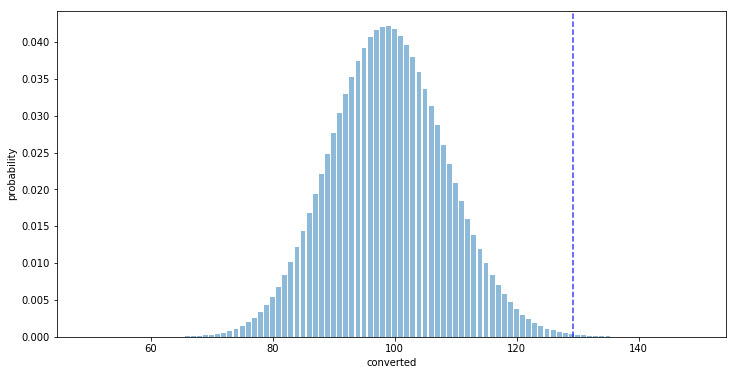

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, A_cr).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=B_cr * A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

In [34]:
p_A = bcr
B_converted = a['converted'][1]
B_total = a['total'][1]
p_B = d_hat + bcr

Text(0, 0.5, 'probability')

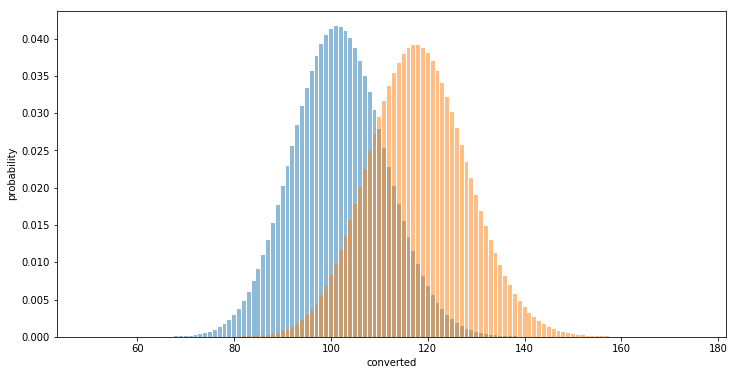

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.bar(xB, yB, alpha=0.5)
plt.xlabel('converted')
plt.ylabel('probability')

Need to take into account:
* sample size difference
* by comparing conversion probability

Bernoulli distribution has *Ep = p*, *V = p(1-p)*

!! Central Limit theorem !!

We can represent both test and control by the normal distribution definted as

p ~ Norm(mu = p, sd = sqrt(p(1-p))/ sqrt(n)

Where n is sample size

In [36]:
# Use test conversion rates as mean
p_A = A_cr
p_B = B_cr

Text(0, 0.5, 'PDF')

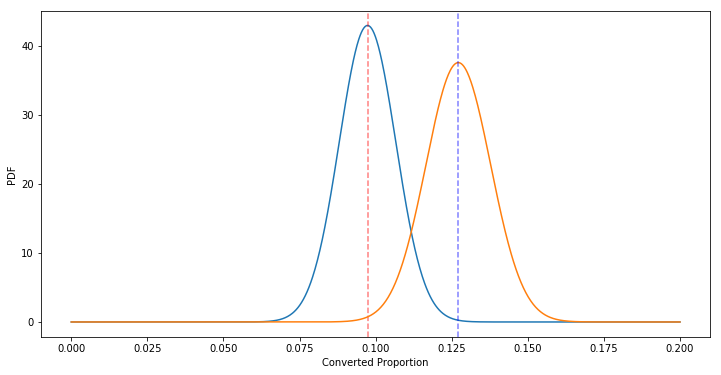

In [37]:
# standard error of the mean for both groups
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)
# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(0, .2, 1000)
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(x, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(x, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

!! Why are we looking at the sum of variances? !!

### Null and Alternative hypothesis

* The null hypothesis is the position that the change in the design made for the test group would result in no change in the conversion rate.
* The alternative hypothesis is the opposing position that the change in the design for the test group would result in an improvement (or reduction) in the conversion rate.

In [38]:
import ab_plot as abp

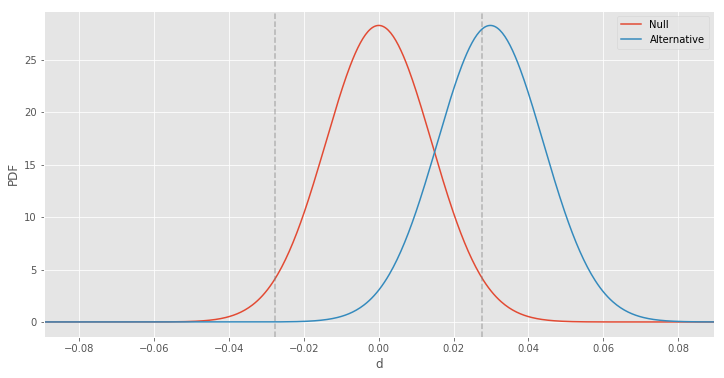

In [47]:
# define the parameters for abplot()
# use the actual values from the experiment for bcr and d_hat
# p_A is the conversion rate of the control group
# p_B is the conversion rate of the test group
n = N_A + N_B
bcr = p_A  
d_hat = p_B - p_A
abp.abplot(N_A, N_B, bcr, d_hat)

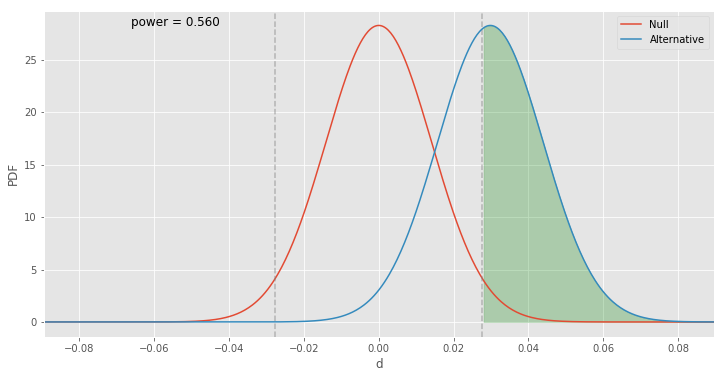

In [49]:
abp.abplot(N_A, N_B, bcr, d_hat, show_power=True)

### Choosing and reviewing a result

Experiments are typically set up for a minimum desired power of 80%. If our new design is truly better, we want our experiment to show that there is at least an 80% probability that this is the case. 

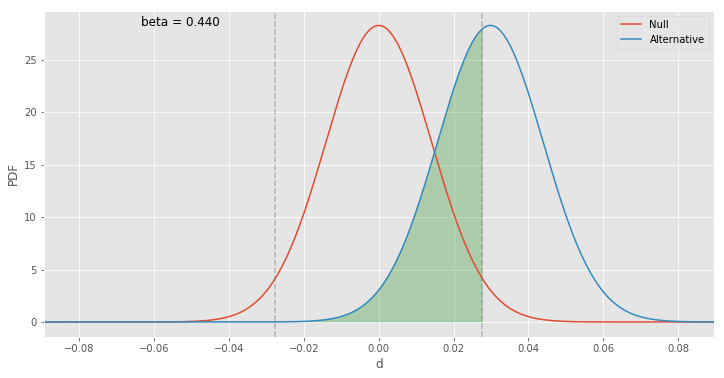

In [55]:
abp.abplot(N_A, N_B, bcr, d_hat, show_beta=True)

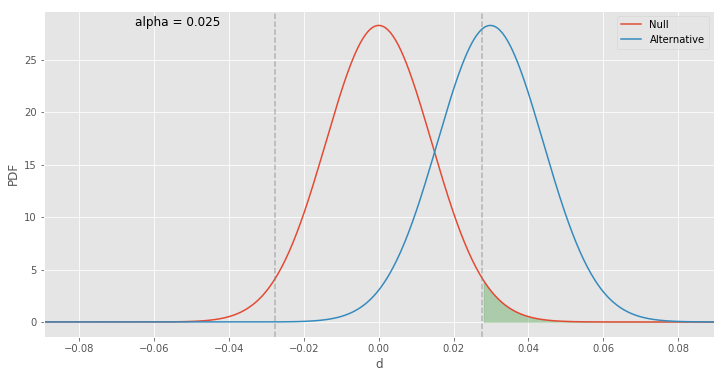

In [54]:
abp.abplot(N_A, N_B, bcr, d_hat, show_alpha=True)

### 5. Sample Size

In [56]:
bcr = p_A

In [58]:
ab_data = generate_data(N_A, N_B, bcr, bcr + d_hat) 

In [60]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [75]:
N_A = ab_summary['total'][0]
N_B = ab_summary['total'][1]
d_hat = ab_summary['rate'][1] - ab_summary['rate'][0]

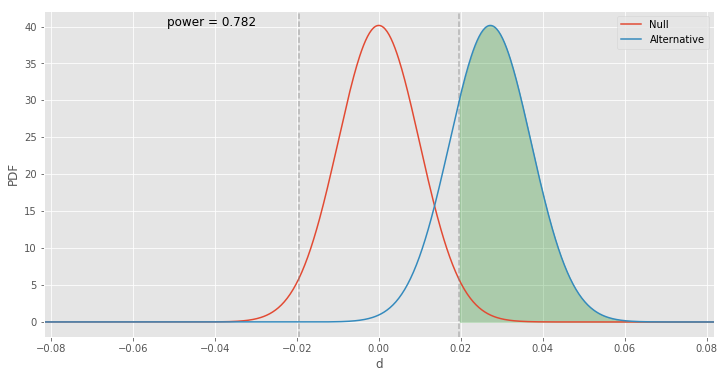

In [76]:
abp.abplot(N_A, N_B, bcr, d_hat, show_power=True)

https://www.optimizely.com/sample-size-calculator/?conversion=10&effect=20&significance=95

Nearly enough to cross 0.8 threshold

In [86]:
import scipy.stats as scs

def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        bcr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        mde (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (bcr + bcr+mde) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N

In [87]:
min_sample_size(bcr=0.10, mde=0.02)

3842.026629963879

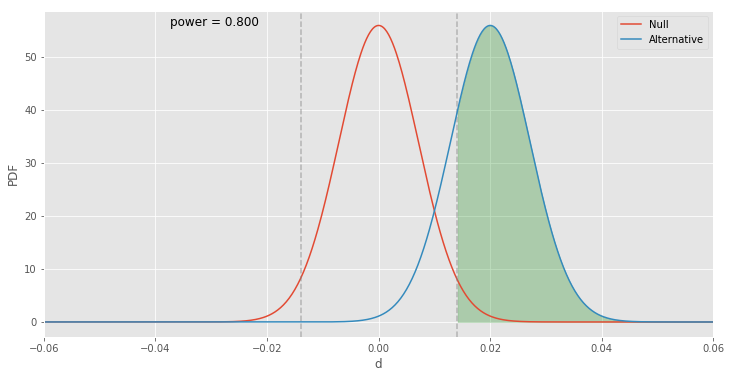

In [85]:
abp.abplot(3843, 3843, 0.10, 0.02, show_power=True)